# Introduction to `laplax` for regression tasks

This tutorial follows the `laplace-torch` regression tutorial. It is a great start to visually understand the posterior Gaussian Process kernel induced by the weight-space Laplace approximation.

In [23]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from helper import DataLoader, get_sinusoid_example
from plotting import plot_regression_with_uncertainty

n_epochs = 1000
key = jax.random.key(0)

# Sample toy data example
num_training_samples = 150
num_calibration_samples = 50
num_test_samples = 100

batch_size = 20
X_train, y_train, X_valid, y_valid, X_test, y_test = get_sinusoid_example(
    num_train_data=num_training_samples,
    num_valid_data=num_calibration_samples,
    num_test_data=num_test_samples,
    sigma_noise=0.3,
    rng_key=jax.random.key(0)
)
train_loader = DataLoader(X_train, y_train, batch_size)

## Training a MAP

In this tutorial, we use `flax.nnx` for training a neural network. Other libraries (e.g., `equinox` or `flax.linen`) should also work out of the box if they are brought into the form of `model_fn` function (taking two arguments, `input`, and `params`) and a `params` PyTree containing the learned parameters you want to do inference over.

In [2]:
# Create and train MAP model
class Model(nnx.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, rngs):
        self.linear1 = nnx.Linear(in_channels, hidden_channels, rngs=rngs)
        self.linear2 = nnx.Linear(hidden_channels, out_channels, rngs=rngs)

    def __call__(self, x):
        x = nnx.tanh(self.linear1(x))
        x = self.linear2(x)
        return x


# Initialize model
model = Model(in_channels=1, hidden_channels=50, out_channels=1, rngs=nnx.Rngs(0))


# Set loss function
def criterion(x, y):
    return jnp.sum((x - y) ** 2)


# Create optimizer
optimizer = nnx.Optimizer(model, optax.adamw(1e-2))  # Reference sharing


@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        y_pred = model(x)  # Call methods directly
        return criterion(y, y_pred)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)  # Inplace updates

    return loss

In [3]:
for epoch in range(n_epochs):
    for x_tr, y_tr in train_loader:
        loss = train_step(model, optimizer, x_tr, y_tr)

    if epoch % 100 == 0:
        print(f"[epoch {epoch}]: loss: {loss:.4f}")

print(f"Final loss: {loss:.4f}")

[epoch 0]: loss: 4.8290
[epoch 100]: loss: 1.1440
[epoch 200]: loss: 0.7200
[epoch 300]: loss: 1.7787
[epoch 400]: loss: 0.2259
[epoch 500]: loss: 0.5114
[epoch 600]: loss: 1.3292
[epoch 700]: loss: 0.4671
[epoch 800]: loss: 0.7203
[epoch 900]: loss: 0.8306
Final loss: 0.8181


## Setup curvature matrix-vector product

In [4]:
from laplax.curv import create_ggn_mv
from laplax.util.loader import input_target_split

# Create GGN
graph_def, params = nnx.split(model)


def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]


train_batch = {"input": X_train, "target": y_train}

ggn_mv = create_ggn_mv(
    model_fn,
    params,
    train_batch,
    loss_fn="mse",
)

In this small toy example, we can dense the curvature matrix-vector product. We start by wrapping the matrix-vector product to accept normal unit vectors (of the size of flattened parameters). This will help us visualize the GGN.

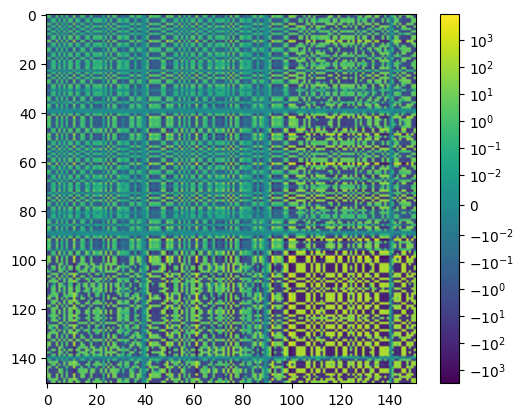

In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

from laplax.util.flatten import flatten_function
from laplax.util.mv import to_dense
from laplax.util.tree import get_size

ggn_mv_wrapped = flatten_function(ggn_mv, params)
arr = to_dense(ggn_mv_wrapped, layout=get_size(params))


plt.imshow(arr, norm=SymLogNorm(linthresh=1e-2, linscale=1))
plt.colorbar()
plt.show()

## Curvature estimators

In practice, we can not afford to dense and continue computations with the GGN. Therefore, various strategies for estimating the curvature exist. Within this package we have: `full` (obvious), `diagonal` and low_rank. For the latter, we support finding the low rank representation using `lanczos` or `lobpcg`. 

In [6]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown for library selection.
lib_dropdown = widgets.Dropdown(
    options=['full', 'diagonal', 'lanczos', 'lobpcg'],
    value='full',
    description='Curv. est.:',
)
display(lib_dropdown)

Dropdown(description='Curv. est.:', options=('full', 'diagonal', 'lanczos', 'lobpcg'), value='full')

In [7]:
print("Curv. est.:", lib_dropdown.value)
curv_type = lib_dropdown.value
low_rank_args = {
    "key": jax.random.key(20),
    "rank": 50,
    "mv_jittable": True,
}
curv_args = {} if curv_type in {"full", "diagonal"} else low_rank_args


Curv. est.: diagonal


In [8]:
from laplax.curv import estimate_curvature

curv_estimate = estimate_curvature(
    curv_type=curv_type,
    mv=ggn_mv,
    layout=params,
    **curv_args,
)


## Create a posterior_fn

We can now create a `posterior_fn` that takes `prior_arguments` and returns a posterior distribution over the weights. If we have already an estimation of the curvature, then we can directly set the posterior function. Otherwise both functions can also be executed at once using the `laplax.curv.create_posterior_fn`. 

In [9]:
from laplax.curv.cov import set_posterior_fn

posterior_fn = set_posterior_fn(curv_type, curv_estimate, layout=params)

# # Alternatively, we can create the posterior function from scratch, if no curvature
# # estimation is available.
# # Create Posterior
# posterior_fn = create_posterior_fn(
#     curv_type=curv_type,
#     mv=ggn_mv,
#     layout=params,
#     **curv_args,
# )

## How to pushforward the weight space uncertainty?

There are three ideas for pushing forward weight space uncertainty.

1. ...

## Linearized push-forward

(200,) (200,)


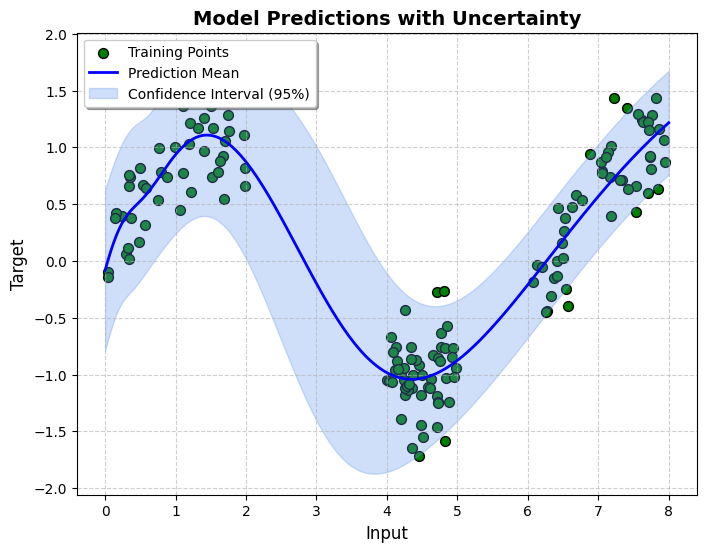

In [20]:
from functools import partial

from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_var,
    lin_setup,
    set_lin_pushforward,
)

# Setup linearized pushforward
set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_var,
    ],
)
prior_arguments = {"prior_prec": 1.0}  # Choose any prior precision.
prob_predictive = set_prob_predictive(
    prior_arguments=prior_arguments,
)

X_range = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_range)
pred_mean = pred["pred_mean"][:, 0]
pred_var = pred["pred_var"][:, 0]
print(pred_mean.shape, pred_var.shape)
plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_range,
    Y_pred=pred_mean,
    Y_var=pred_var,
)

### Non-linear push-forward

(200,) (200,)


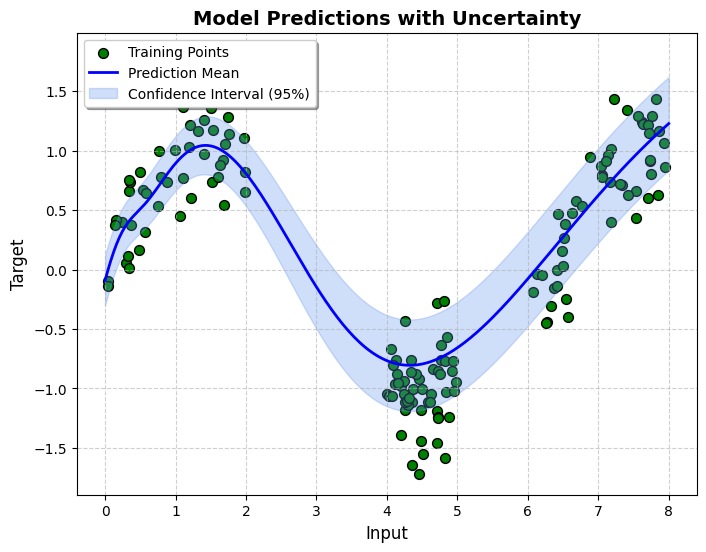

In [21]:
from functools import partial

from laplax.eval.pushforward import (
    nonlin_pred_mean,
    nonlin_pred_var,
    nonlin_setup,
    set_nonlin_pushforward,
)

# Setup linearized pushforward
set_nonlin_prob_predictive = partial(
    set_nonlin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        nonlin_setup,
        nonlin_pred_mean,
        nonlin_pred_var,
    ],
    key=jax.random.key(42),
    num_samples=10000,
)
prior_arguments = {"prior_prec": 60.}  # Choose any prior precision.
prob_predictive = set_nonlin_prob_predictive(
    prior_arguments=prior_arguments,
)

X_test = jnp.linspace(0, 8, 200).reshape(200, 1)
pred = jax.vmap(prob_predictive)(X_test)
pred_mean = pred["pred_mean"][:, 0]
pred_var = pred["pred_var"][:, 0]
print(pred_mean.shape, pred_var.shape)
plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_test,
    Y_pred=pred_mean,
    Y_var=pred_var,
)

## Calibration

### Grid search

In [25]:
from functools import partial

from laplax.eval.calibrate import (
    evaluate_for_given_prior_arguments,
    optimize_prior_prec,
)
from laplax.eval.metrics import nll_gaussian
from laplax.eval.pushforward import (
    lin_pred_mean,
    lin_pred_std,
    lin_setup,
    set_lin_pushforward,
)

set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_std,
    ],
)

clbr_batch = {"input": X_valid, "target": y_valid}

### Target: Negative Log-Likelihood

In [26]:
def calibration_objective(prior_arguments):
    return evaluate_for_given_prior_arguments(
        prior_arguments=prior_arguments,
        data=clbr_batch,
        set_prob_predictive=set_prob_predictive,
        metric=nll_gaussian,
    )


prior_prec_nll_gaussian = optimize_prior_prec(
    objective=calibration_objective,
    log_prior_prec_min=-3.0,
    log_prior_prec_max=3.0,
    grid_size=50,
    patience=50 # TODO: Remove this as a default argument.
)

print("Calibrated prior precision: ", prior_prec_nll_gaussian.item())

2025-04-11 19:31:00.902 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0653 seconds, prior prec: 0.0010, result: 0.554060
2025-04-11 19:31:00.976 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0730 seconds, prior prec: 0.0013, result: 0.552812
2025-04-11 19:31:01.043 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0668 seconds, prior prec: 0.0018, result: 0.551498
2025-04-11 19:31:01.105 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0611 seconds, prior prec: 0.0023, result: 0.550081
2025-04-11 19:31:01.172 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0670 seconds, prior prec: 0.0031, result: 0.548518
2025-04-11 19:31:01.238 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0651 seconds, prior prec: 0.0041, result: 0.546765
2025-04-11 19:31:01.300 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0616 seconds, prior prec: 0.0054, result: 0.544774
2025-04-11 19:31:01.364 | INFO     | laplax.eval.calibr

Calibrated prior precision:  323.7457580566406


### Target: Marginal-Log Likelihood

In [27]:
from laplax.enums import LossFn
from laplax.eval import marginal_log_likelihood


def marglik_objective(prior_arguments):
    return - marginal_log_likelihood(
        curv_estimate,
        prior_arguments=prior_arguments,
        data=clbr_batch,
        model_fn=model_fn,
        params=params,
        loss_fn=LossFn.MSE,
        curv_type=curv_type,
    )


prior_prec_marglik = optimize_prior_prec(
    objective=marglik_objective,
    log_prior_prec_min=-3.0,
    log_prior_prec_max=3.0,
    grid_size=50,
    patience=50  # TODO: Remove this as a default argument.
)

print("Calibrated prior precision: ", prior_prec_marglik.item())

2025-04-11 19:31:05.304 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0037 seconds, prior prec: 0.0010, result: 636.592041
2025-04-11 19:31:05.307 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0031 seconds, prior prec: 0.0013, result: 616.388733
2025-04-11 19:31:05.310 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0023 seconds, prior prec: 0.0018, result: 596.255005
2025-04-11 19:31:05.313 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0022 seconds, prior prec: 0.0023, result: 576.199951
2025-04-11 19:31:05.315 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0017 seconds, prior prec: 0.0031, result: 556.236023
2025-04-11 19:31:05.317 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0017 seconds, prior prec: 0.0041, result: 536.378906
2025-04-11 19:31:05.319 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0017 seconds, prior prec: 0.0054, result: 516.649109
2025-04-11 19:31:05.321 | INFO     | lapl

Calibrated prior precision:  0.6551287174224854


### Evaluate regression metrics on full dataset

In [40]:
import pandas as pd

from laplax.eval.metrics import DEFAULT_REGRESSION_METRICS
from laplax.eval.utils import evaluate_metrics_on_dataset

test_batch = {"input": X_test, "target": y_test}

prob_predictive_no_clbr = set_prob_predictive(prior_arguments={"prior_prec": .001})
pred_no_clbr = jax.vmap(prob_predictive_no_clbr)(X_range)
results_no_clbr = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive_no_clbr,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,
)

prob_predictive_nll_gaussian = set_prob_predictive(
    prior_arguments={"prior_prec": prior_prec_nll_gaussian}
)
pred_nll_gaussian = jax.vmap(prob_predictive_nll_gaussian)(X_range)
results_nll_gaussian = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive_nll_gaussian,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,
)

prob_predictive_marglik = set_prob_predictive(
    prior_arguments={"prior_prec": prior_prec_marglik}
)
pred_marglik = jax.vmap(prob_predictive_marglik)(X_range)
results_marglik = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive_marglik,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,
)


# Create a DataFrame with the results
results_df = pd.DataFrame({
    'No Calibration': results_no_clbr,
    'NLL Gaussian': results_nll_gaussian,
    'Marginal Likelihood': results_marglik
})

# Display the table
display(results_df)

,No Calibration,NLL Gaussian,Marginal Likelihood
crps,0.23000823,0.19852886,0.21396828
nll,0.66932815,0.4346905,0.56630945
q,0.26703334,1.5844655,0.32284185
rmse,0.27049467,0.27049467,0.27049467


In [57]:
import matplotlib.pyplot as plt
import numpy as np


def plot_multiple_regression_comparisons(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    predictions_dict: dict[str, dict[str, np.ndarray]],
    figsize: tuple = (18, 6),
    suptitle: str = "Comparison of Different Calibration Methods",
    train_label: str = "Training Data",
    confidence_alpha: float = 0.3,
) -> plt.Figure:
    """Create side-by-side regression plots with uncertainty for multiple methods.

    Args:
        X_train: Training input data
        y_train: Training target data
        X_test: Test input data
        predictions_dict: Dictionary of dictionaries, where outer keys are method names
                         and inner dictionaries contain 'mean' and 'std' arrays
        figsize: Figure size as (width, height)
        suptitle: Super title for the entire figure
        train_label: Label for training data
        test_label: Label for test data
        confidence_alpha: Alpha value for confidence interval
        save_path: Optional path to save the figure

    Returns:
        The matplotlib figure object
    """
    # Create figure with subplots
    n_methods = len(predictions_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=figsize, sharey=True)

    # If only one method, make axes iterable
    if n_methods == 1:
        axes = [axes]

    # Plot each method
    for i, (method_name, predictions) in enumerate(predictions_dict.items()):
        ax = axes[i]

        # Get predictions
        y_pred = predictions['mean']
        y_std = np.sqrt(predictions.get('var', 0.0))  # Get standard deviation from variance

        # Plot training data
        ax.scatter(X_train, y_train, color='#1f77b4', alpha=0.7, s=30, label=train_label)

        # Plot mean prediction
        ax.plot(X_test, y_pred, color='#ff7f0e', label='Mean Prediction')

        # Plot uncertainty if variance provided
        if 'var' in predictions:
            ax.fill_between(
                X_test.flatten(),
                (y_pred - 1.96 * y_std).flatten(),
                (y_pred + 1.96 * y_std).flatten(),
                color='#ff7f0e', alpha=confidence_alpha, label='95% Confidence'
            )

        # Set title and labels
        ax.set_title(method_name, fontsize=14)
        ax.set_xlabel('X', fontsize=12)
        if i == 0:
            ax.set_ylabel('y', fontsize=12)

        # Add grid
        ax.grid(linestyle='--', alpha=0.7)

        # Add metrics if available
        if 'metrics' in predictions:
            metrics_text = "\n".join([f"{k}: {v:.4f}" for k, v in predictions['metrics'].items()])
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
                    verticalalignment='top', 
                    bbox={"boxstyle": 'round', "facecolor": 'white', "alpha": 0.8}
            )

    # Add legend to the first subplot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
               ncol=min(4, len(handles)), frameon=True, fontsize=12)

    # Add super title
    fig.suptitle(suptitle, fontsize=16, y=0.98)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])

    return fig

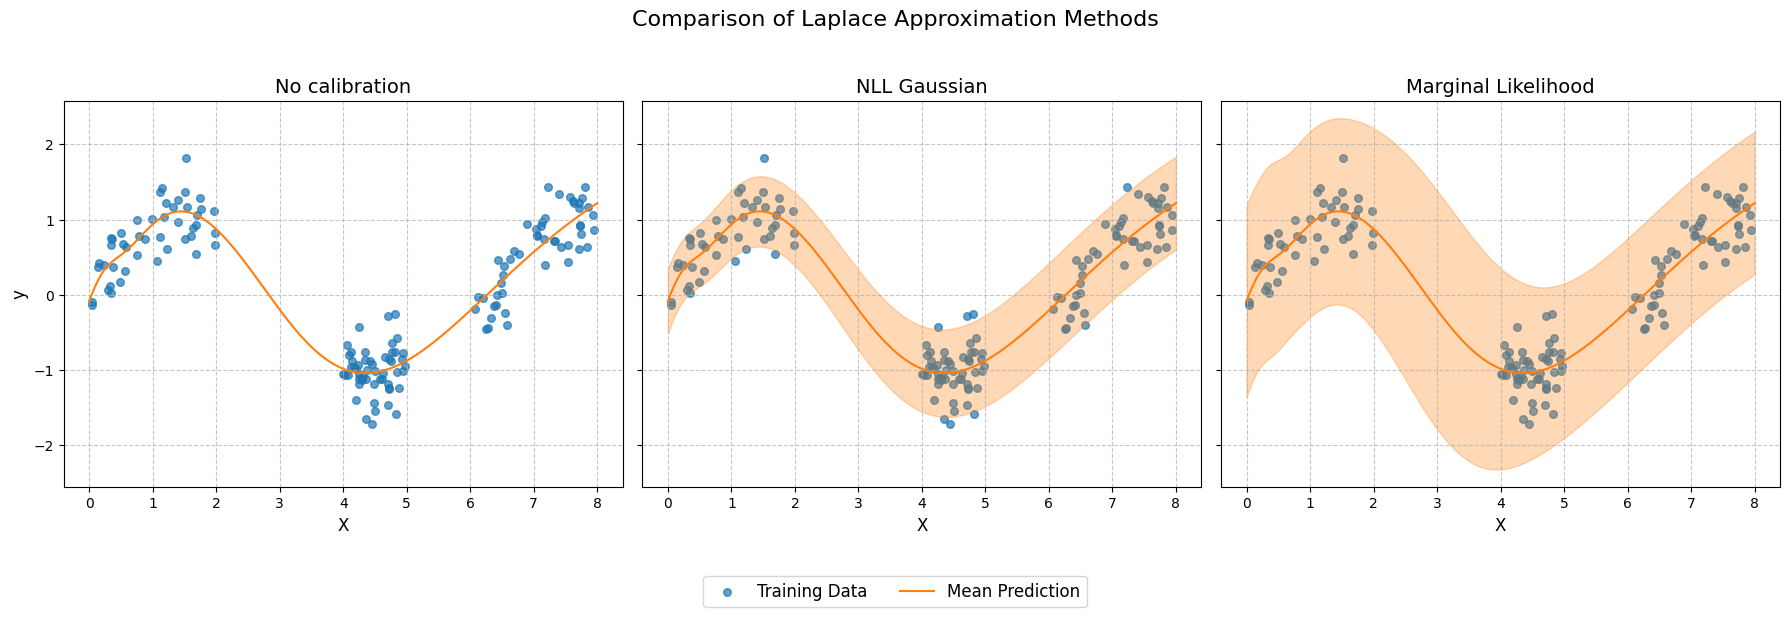

In [58]:
# After running your different calibration methods and collecting results
# Assuming you have predictions and uncertainties from different methods

# Create a dictionary to hold predictions from different methods
predictions_dict = {
    "No calibration": {
        "mean": pred_no_clbr["pred_mean"][:, 0],
        "std": np.sqrt(pred_no_clbr["pred_var"][:, 0]),
    },
    "NLL Gaussian": {
        "mean": pred_nll_gaussian["pred_mean"][:, 0],
        "var": pred_nll_gaussian["pred_var"][:, 0],
    },
    "Marginal Likelihood": {
        "mean": pred_marglik["pred_mean"][:, 0],
        "var": pred_marglik["pred_var"][:, 0],
    }
}

# Create the comparison plot
fig = plot_multiple_regression_comparisons(
    X_train=X_train,
    y_train=y_train,
    X_test=X_range,  # Use your X_range from the notebook
    predictions_dict=predictions_dict,
    suptitle="Comparison of Laplace Approximation Methods",
)

# Show the plot
plt.show()

## Modeling observation noise

## Bonus: Registering `skerch`

In [69]:
import torch
from skerch import linops
from skerch.decompositions import seigh

from laplax.curv import register_curvature_method
from laplax.curv.utils import LowRankTerms, get_matvec
from laplax.types import DType


class JAXMV(linops.TorchLinOpWrapper):
    def __init__(self, matvec, shape):
        self.shape = shape
        self.matvec = matvec

    def __matmul__(self, x):
        x_dtype = x.dtype
        x = jnp.asarray(x.detach().cpu().numpy())
        x = self.matvec(x)
        return torch.tensor(np.asarray(x), dtype=x_dtype)

    def __rmatmul__(self, x):
        return self.__matmul__(x.T)


def skerch_low_rank(
    A,
    *,
    layout=None,
    rank: int = 100,
    return_dtype: DType = jnp.float64,
    mv_jittable=True,
    **kwargs,
):
    del kwargs
    # Setup mv product.
    matvec, size = get_matvec(A, layout=layout, jit=mv_jittable)
    op = JAXMV(matvec, (size, size))

    res = seigh(
        op, op_device="cpu", op_dtype=torch.float64, outer_dim=rank, inner_dim=rank
    )

    low_rank_result = LowRankTerms(
        U=jnp.asarray((res[0] @ res[1]).detach().cpu()),
        S=jnp.asarray(res[2].detach().cpu().numpy()),
        scalar=jnp.asarray(0.0, dtype=return_dtype),
    )
    # TODO: Introduce mixed types as in other low rank methods.
    return low_rank_result


register_curvature_method(name="skerch", create_fn=skerch_low_rank, default="lanczos")

In [71]:
curv = estimate_curvature(
    curv_type="skerch",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    rank=50,
    mv_jittable=True,
)

/tmp/ipykernel_196241/1870432125.py:46: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  scalar=jnp.asarray(0.0, dtype=return_dtype),


## Bonus: Posterior GP kernel

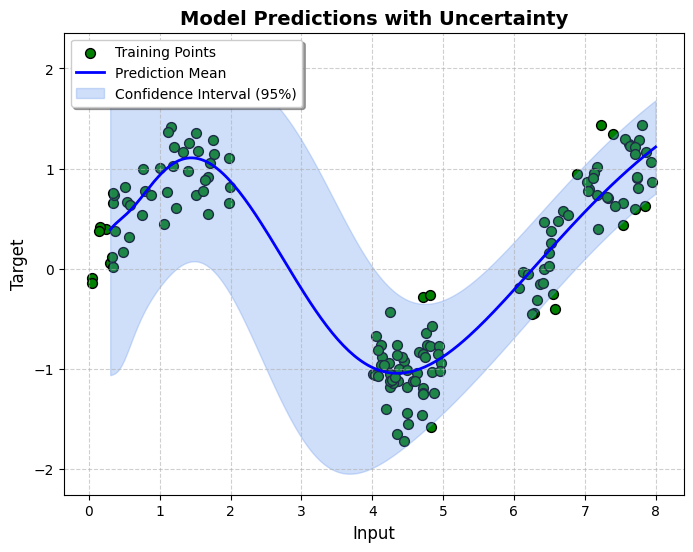

In [75]:
from laplax.eval.pushforward import set_posterior_gp_kernel

prior_arguments = {"prior_prec": 0.1}

gp_kernel, dist_state = set_posterior_gp_kernel(
    model_fn=model_fn,
    mean=params,
    posterior_fn=posterior_fn,
    prior_arguments=prior_arguments,
    dense=True,  # If dense = False, then a kernel-vector product is returned.
    output_layout=1,
)

X_grid = jnp.linspace(0.3, 8, 200).reshape(200, 1)
Y_pred = model_fn(X_grid, params)[:, 0]

Y_var = jax.jit(jax.vmap(lambda x: gp_kernel(x, x)))(X_grid)[:, 0, 0]

plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_grid,
    Y_pred=Y_pred,
    Y_var=Y_var,
)

## Bonus: Model selection

## Setup Low Rank Laplace

In [76]:
from laplax.curv.cov import create_posterior_fn

# Create Posterior
posterior_fn = create_posterior_fn(
    "lanczos",
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    maxiter=50,
    mv_jittable=True,
)

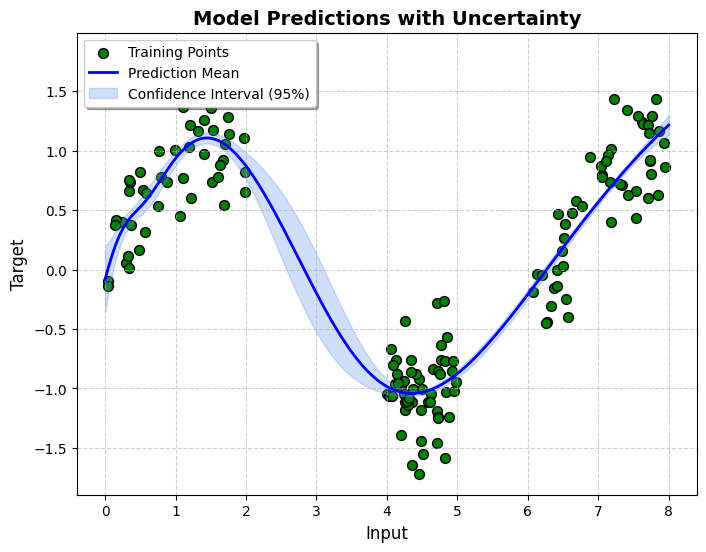

In [77]:
from laplax.eval.pushforward import set_posterior_gp_kernel

prior_arguments = {"prior_prec": 1.0}

gp_kernel, _ = set_posterior_gp_kernel(
    model_fn=model_fn,
    mean=params,
    posterior_fn=posterior_fn,
    prior_arguments=prior_arguments,
    dense=True,  # If dense = False, then a kernel-vector product is returned.
    output_layout=1,
)

X_grid = jnp.linspace(0.0, 8, 200).reshape(200, 1)
Y_pred = model_fn(X_grid, params)[:, 0]
Y_var = jax.jit(jax.vmap(lambda x: gp_kernel(x, x)))(X_grid)[:, 0, 0]

plot_regression_with_uncertainty(
    train_input=train_batch["input"],
    train_target=train_batch["target"],
    X_grid=X_grid,
    Y_pred=Y_pred,
    Y_var=Y_var,
)

## Calibration

### Grid search

In [78]:
from functools import partial

from laplax.eval.pushforward import (
    set_lin_pushforward,
    lin_setup,
    lin_pred_mean,
    lin_pred_std,
)

from laplax.eval.calibrate import (
    evaluate_for_given_prior_arguments,
    optimize_prior_prec,
)

set_prob_predictive = partial(
    set_lin_pushforward,
    model_fn=model_fn,
    mean_params=params,
    posterior_fn=posterior_fn,
    pushforward_fns=[
        lin_setup,
        lin_pred_mean,
        lin_pred_std,
    ],
)

In [79]:
from laplax.eval.calibrate import calibration_metric

clbr_batch = {"input": X_valid, "target": y_valid}


def calibration_objective(prior_arguments):
    return evaluate_for_given_prior_arguments(
        prior_arguments=prior_arguments,
        data=clbr_batch,
        set_prob_predictive=set_prob_predictive,
        metric=calibration_metric,
    )


prior_prec_chi_squared = optimize_prior_prec(
    objective=calibration_objective,
    log_prior_prec_min=-3.0,
    log_prior_prec_max=3.0,
    grid_size=50,
    patience=50, # TODO: Remove this as a default argument.
)

2025-04-11 19:54:46.827 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.3382 seconds, prior prec: 0.0010, result: 1.619253
2025-04-11 19:54:46.985 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1580 seconds, prior prec: 0.0013, result: 1.428558
2025-04-11 19:54:47.147 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1615 seconds, prior prec: 0.0018, result: 1.428175
2025-04-11 19:54:47.322 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1734 seconds, prior prec: 0.0023, result: 1.922327
2025-04-11 19:54:47.322 | INFO     | laplax.eval.calibrate:grid_search:143 - Result increased, increasing_count = 1
2025-04-11 19:54:47.472 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1491 seconds, prior prec: 0.0031, result: 1.946990
2025-04-11 19:54:47.473 | INFO     | laplax.eval.calibrate:grid_search:143 - Result increased, increasing_count = 2
2025-04-11 19:54:47.617 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1439 seco

In [11]:
from laplax.eval.metrics import nll_gaussian


def calibration_objective(prior_arguments):
    return evaluate_for_given_prior_arguments(
        prior_arguments=prior_arguments,
        data=clbr_batch,
        set_prob_predictive=set_prob_predictive,
        metric=nll_gaussian,
    )


prior_prec_nll_gaussian = optimize_prior_prec(
    objective=calibration_objective,
    log_prior_prec_min=-3.0,
    log_prior_prec_max=3.0,
    grid_size=100,
    patience=100, # TODO: Remove this as a default argument.
)

2025-04-11 16:57:56.439 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.2659 seconds, prior prec: 0.0010, result: 0.808216
2025-04-11 16:57:56.658 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.2185 seconds, prior prec: 0.0011, result: 0.800062
2025-04-11 16:57:56.801 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1430 seconds, prior prec: 0.0013, result: 0.793406
2025-04-11 16:57:56.942 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1397 seconds, prior prec: 0.0015, result: 0.786976
2025-04-11 16:57:57.087 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1444 seconds, prior prec: 0.0017, result: 0.779398
2025-04-11 16:57:57.229 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1411 seconds, prior prec: 0.0020, result: 0.772971
2025-04-11 16:57:57.373 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.1430 seconds, prior prec: 0.0023, result: 0.765966
2025-04-11 16:57:57.553 | INFO     | laplax.eval.calibr

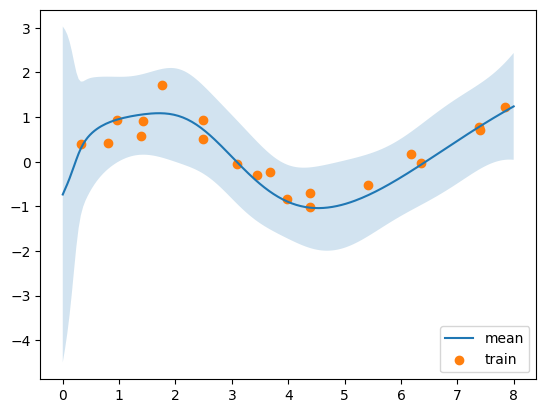

In [12]:
import matplotlib.pyplot as plt

prob_predictive_no_clbr = set_prob_predictive(prior_arguments={"prior_prec": 1.0})
input_points = jnp.linspace(0, 8, 200).reshape(200, 1)
results = jax.vmap(prob_predictive_no_clbr)(input_points)


plt.plot(input_points[:, 0], results["pred_mean"], label="mean")
plt.fill_between(
    input_points[:, 0],
    (results["pred_mean"] - 1.96 * results["pred_std"])[:, 0],
    (results["pred_mean"] + 1.96 * results["pred_std"])[:, 0],
    alpha=0.2,
)
plt.scatter(train_batch["input"][:, 0], train_batch["target"], label="train")
plt.legend()
plt.show()


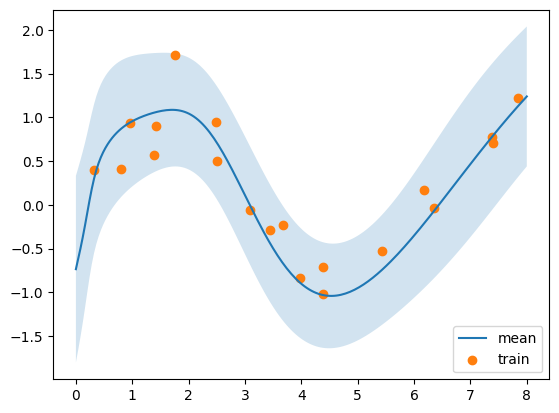

In [13]:
import matplotlib.pyplot as plt

prob_predictive_nll_gaussian = set_prob_predictive(prior_arguments={"prior_prec": prior_prec_nll_gaussian})
input_points = jnp.linspace(0, 8, 200).reshape(200, 1)
results = jax.vmap(prob_predictive_nll_gaussian)(input_points)


plt.plot(input_points[:, 0], results["pred_mean"], label="mean")
plt.fill_between(
    input_points[:, 0],
    (results["pred_mean"] - 1.96 * results["pred_std"])[:, 0],
    (results["pred_mean"] + 1.96 * results["pred_std"])[:, 0],
    alpha=0.2,
)
plt.scatter(train_batch["input"][:, 0], train_batch["target"], label="train")
plt.legend()
plt.show()

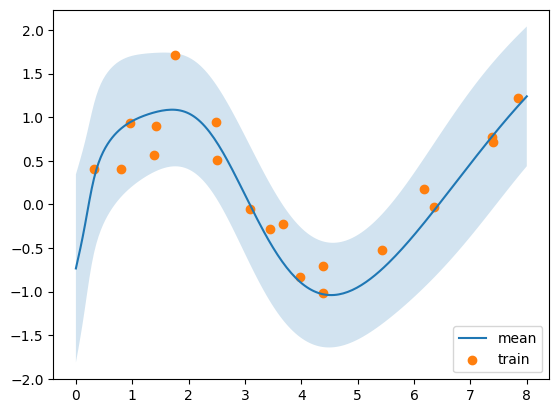

In [14]:
import matplotlib.pyplot as plt

prob_predictive_chi_squared = set_prob_predictive(prior_arguments={"prior_prec": prior_prec_chi_squared})
input_points = jnp.linspace(0, 8, 200).reshape(200, 1)
results = jax.vmap(prob_predictive_chi_squared)(input_points)


plt.plot(input_points[:, 0], results["pred_mean"], label="mean")
plt.fill_between(
    input_points[:, 0],
    (results["pred_mean"] - 1.96 * results["pred_std"])[:, 0],
    (results["pred_mean"] + 1.96 * results["pred_std"])[:, 0],
    alpha=0.2,
)
plt.scatter(train_batch["input"][:, 0], train_batch["target"], label="train")
plt.legend()
plt.show()

In [23]:
from laplax.eval.utils import evaluate_metrics_on_dataset
from laplax.eval.metrics import DEFAULT_REGRESSION_METRICS

# x_test = jnp.linspace(0, 10, 200).reshape(200, 1)
# y_test = jnp.sin(x_test)
test_batch = {"input": X_test, "target": y_test}

results_no_clbr = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive_no_clbr,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,
)

results_nll_gaussian = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive_nll_gaussian,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,
)

results_chi_squared = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive_chi_squared,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,
)

print(results_no_clbr)
print(results_nll_gaussian)
print(results_chi_squared)

{'crps': Array(0.20085496, dtype=float32), 'nll': Array(0.45904922, dtype=float32), 'q': Array(0.43991914, dtype=float32), 'rmse': Array(0.26349008, dtype=float32)}
{'crps': Array(0.1883044, dtype=float32), 'nll': Array(0.33190772, dtype=float32), 'q': Array(0.8677885, dtype=float32), 'rmse': Array(0.26349008, dtype=float32)}
{'crps': Array(0.18832672, dtype=float32), 'nll': Array(0.3322164, dtype=float32), 'q': Array(0.86148304, dtype=float32), 'rmse': Array(0.26349008, dtype=float32)}


## Calibration using Marginal Log-Likelihood

In [42]:
from laplax.curv.cov import estimate_curvature
from laplax.eval.likelihood import marginal_log_likelihood
from laplax.enums import CurvApprox, LossFn

curv = estimate_curvature(
    curv_type=CurvApprox.LANCZOS,
    mv=ggn_mv,
    layout=params,
    key=jax.random.key(20),
    maxiter=50,
    mv_jittable=True,
)

In [43]:
marginal_log_likelihood(
    curv,
    prior_arguments={"prior_prec": 0.001},
    data=clbr_batch,
    model_fn=model_fn,
    params=params,
    loss_fn=LossFn.MSE,
    curv_type=CurvApprox.LANCZOS,
)

Array(-460.32718, dtype=float32)

In [44]:
from laplax.curv.utils import concatenate_model_and_loss_fn

full_fn = concatenate_model_and_loss_fn(
    model_fn=model_fn,
    loss_fn=LossFn.MSE,
    has_batch=True,
)

In [53]:
@jax.jit
def calibration_objective(prior_arguments):
    return - marginal_log_likelihood(
        curv,
        prior_arguments=prior_arguments,
        data=clbr_batch,
        model_fn=model_fn,
        params=params,
        loss_fn=LossFn.MSE,
        curv_type=CurvApprox.LANCZOS,
    )


prior_prec_nll_gaussian = optimize_prior_prec(
    objective=calibration_objective,
    log_prior_prec_min=-6.0,
    log_prior_prec_max=6.0,
    grid_size=100,
    patience=100,  # TODO: Remove this as a default argument.
)

results_nll_gaussian = evaluate_metrics_on_dataset(
    pred_fn=prob_predictive_nll_gaussian,
    data=test_batch,
    metrics=DEFAULT_REGRESSION_METRICS,
    reduce=jnp.mean,
)

2025-04-11 17:03:22.886 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0415 seconds, prior prec: 0.0000, result: 912.110352
2025-04-11 17:03:22.887 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0002 seconds, prior prec: 0.0000, result: 893.829468
2025-04-11 17:03:22.887 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0000 seconds, prior prec: 0.0000, result: 875.548767
2025-04-11 17:03:22.888 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0000 seconds, prior prec: 0.0000, result: 857.268250
2025-04-11 17:03:22.888 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0001 seconds, prior prec: 0.0000, result: 838.987793
2025-04-11 17:03:22.889 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0001 seconds, prior prec: 0.0000, result: 820.707642
2025-04-11 17:03:22.889 | INFO     | laplax.eval.calibrate:grid_search:130 - Took 0.0001 seconds, prior prec: 0.0000, result: 802.427612
2025-04-11 17:03:22.889 | INFO     | lapl

## Using Gradient Descent for calibration

In [ ]:
num_epochs = 5
lr = 1e-1

# Initialize prior arguments
prior_arguments = {"prior_prec": jnp.array(1.0)}

# Set optimizer
optimizer = optax.adam(lr)

# Initialize state
opt_state = optimizer.init(prior_arguments)

# Create data loader
train_loader = DataLoader(X_data, y_data, batch_size=32)


# Calibration step
@jax.jit
def objective_fn(prior_args, data):
    return - marginal_log_likelihood(
        curv,
        prior_arguments=prior_args,
        data=data,
        model_fn=model_fn,
        params=params,
        loss_fn=LossFn.MSE,
        curv_type=CurvApprox.LANCZOS,
    )


# Training loop for calibration
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    print("-" * 100)
    for i, batch in enumerate(train_loader):
        # Compute the objective value and its gradient with respect to prior_arguments
        obj, grads = jax.value_and_grad(
            lambda p: objective_fn(p, input_target_split(batch))
        )(prior_arguments)

        # Update the parameters using the optimizer
        updates, opt_state = optimizer.update(grads, opt_state)
        prior_arguments = optax.apply_updates(prior_arguments, updates)

        # Print progress every 100 iterations
        if i % 2 == 0:
            print(f"Iteration {i}: Objective = {obj}")

# Print the final prior arguments
obj = objective_fn(prior_arguments, {"input": X_data, "target": y_data})
print(f"Final prior arguments: {prior_arguments}")
print(f"Final objective value: {obj}")

Epoch 0
----------------------------------------------------------------------------------------------------
Iteration 0: Objective = 103.59431457519531
Iteration 2: Objective = 99.10281372070312
Iteration 4: Objective = 97.78338623046875
Epoch 1
----------------------------------------------------------------------------------------------------
Iteration 0: Objective = 98.4560546875
Iteration 2: Objective = 100.20350646972656
Iteration 4: Objective = 98.77995300292969
Epoch 2
----------------------------------------------------------------------------------------------------
Iteration 0: Objective = 97.90821838378906
Iteration 2: Objective = 98.77020263671875
Iteration 4: Objective = 98.11994934082031
Epoch 3
----------------------------------------------------------------------------------------------------
Iteration 0: Objective = 98.02095031738281
Iteration 2: Objective = 99.43312072753906
Iteration 4: Objective = 97.55970764160156
Epoch 4
------------------------------------------